---

# <b>Convex Optimization - Homework 3

### Matteo MARENGO - matteo.marengo@ens-paris-saclay.fr
## <b>Date: 20 / 11 / 2023</b>
---

# <b><center>  Implement the barrier method to solve QP

----

In [13]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cvxpy as cp 
from sklearn.datasets import make_regression

In [14]:
# Parameters for the Barrier method
# tolerance eps > 0
eps = 1e-4
t0 = 1

# Parameters for the Newton method
eps_newton = 1e-5

# Parameters for the backtracking line search
# alpha in [0, 0.5]
alpha  = 0.01 
# beta in [0, 1]
beta = 0.5

# List of values for the parameter mu
# mu > 1
# large mu means fewer outer iterations but more inner (Newton) iterations
mu_list = [2, 10, 15, 25, 50, 100, 200,500,600]

# Parameters for the Ridge regression
n = 75
d = 150
regularization_lambda = 10

----

## <b>1 - Write a function v_seq = centering_step(Q,p,A,b,t,v0,eps)

### <b>1.a -  Define the functions

In [15]:
def objectf(Q,p,v):
    quadratic_part = v.T @ Q @ v
    linear_part = p.T @ v
    return quadratic_part + linear_part

def ftotal(Q,p,A,b,t,v):
    Av = A @ v
    constraint_value = Av - b 
    if np.any(constraint_value >= 0): 
        return None
    return (t * objectf(Q, p, v) - np.sum(np.log(-constraint_value)))

def gradient_f (Q, p, A, b, t, v) :
    Qv = Q @ v
    Av = A @ v
    return t * (2*Qv + p) - A.T @ (1 / (b - Av))

def hessian_f (Q, p, A, b, t, v) : 
    Av = A @ v
    aux  = (1 /((b - Av)**2)).reshape(-1)
    sted = A.T @ np.diag(aux) @ A
    return t * (2*Q) - sted

### <b> 1.b -  Backtracking Line Search

In [16]:
def comparison_criterion(Q,p,A,b,t,v,dv):
    value_of_f = ftotal(Q,p,A,b,t,v)
    if value_of_f != None : 
        cond2 = value_of_f + alpha * t * np.dot((gradient_f(Q, p, A, b, t, v)).T, dv)
        # If the Armijo condition is satisfied
        return value_of_f >= cond2
    return False

def backtrack_line_search (Q, p, A, b, t, v, dv) :
    # start at t = 1
    t_update = 1  
    while True : 
        v_update = v + t_update * dv
        # check if the new point is feasible
        if not comparison_criterion(Q,p,A,b,t,v_update,dv):
            break
        # update t
        t_update = t_update * beta
    return t_update

### <b> 1.c -  Centering Step | Newton's Method

In [17]:
def lambda_and_dv_compute(Q, p, A, b, t, v) : 
    grad = gradient_f(Q, p, A, b, t, v)
    hess = hessian_f(Q, p, A, b, t, v)
    # Compute the Newton step
    dv = - np.linalg.solve(hess, grad)
    # Compute the Newton decrement
    lmbda_2 = - grad.T @ dv
    return lmbda_2,dv

def centering_step(Q, p, A, b, t, v0, eps) : 
    v_seq = [v0]
    v_upd = v0
    lmbda_2,dv  = lambda_and_dv_compute(Q, p, A, b, t, v_upd)
    # Stopping criterion
    while lmbda_2 / 2 > eps :
        # Line Search: Choose step stize by backtracking line search
        step_size = backtrack_line_search (Q, p, A, b, t, v_upd, dv)

        # Update the solution       
        v_upd = v_upd + step_size * dv 
        v_seq.append(v_upd)

        lmbda_2,dv  = lambda_and_dv_compute(Q, p, A, b, t, v_upd)
    
    return v_seq

----

## <b>2 - Write a function v_seq = barr_method(Q,p,A,b,v0,eps)</b>

In [18]:
def barr_method (Q, p, A, b, v0, eps) : 
    
    num_cons = A.shape[0] # number of constraints
    v_upd = v0 # initial point
    t = t0
    v_seq = [v0]
  
    # Stopping criterion
    while (num_cons/t)>= eps : 
        # STEP 1
        # Centering step
        v_upd = centering_step(Q, p, A, b, t, v_upd, eps_newton)
        
        # STEP 2
        # Update the solution
        v_upd = v_upd[-1] # take the last element of the list
        v_seq.append(v_upd)

        # STEP 4 
        # Increase the value of t
        t *= mu 

    return v_seq 

----

## <b>3 - Test the Barrier Method</b>

### <b> 3.a -  Generate random matrices & Variables for QP

In [19]:
# Random Generated Matrices X and observations y and weights w for the regressor 
X, y, w_true = make_regression( n_samples = n , n_features = d, coef=True, random_state=123,noise=5)
y = y.reshape(-1 , 1)
# w_true = w_true.reshape(-1 , 1)

# Define the matrices for the optimization problem
Q = 0.5*np.eye(n)
A = np.vstack((X.T , -X.T))
p = - y
b = regularization_lambda * np.ones((2*d,1))
v0 = np.zeros((n,1))

### <b> 3.b -  Duality Gap

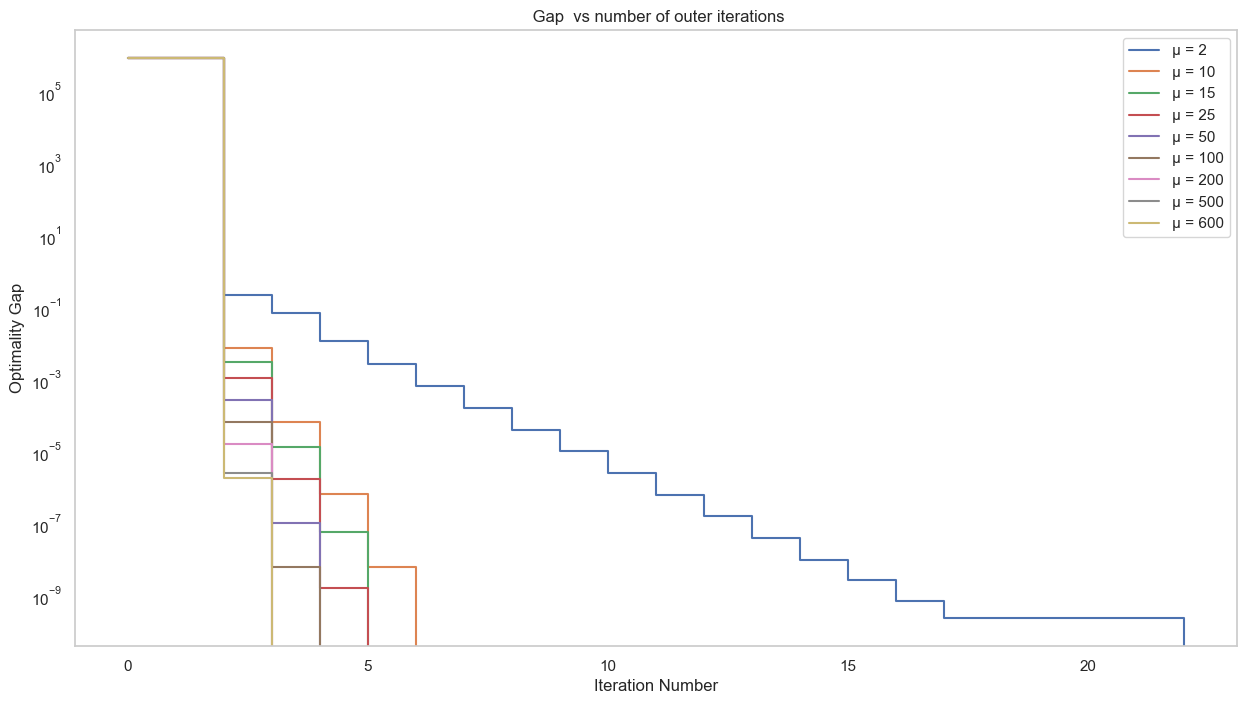

In [20]:
plt.figure(figsize=(15,8))

for mu in mu_list : 
    # Run the barrier method
    # Output: list of v for each iteration
    v_seq = barr_method (Q, p, A, b, v0, eps)
    gap = [objectf(Q, p, v) - objectf(Q, p, v_seq[-1]) for v in v_seq]
    plt.step(range(len(gap)), np.squeeze(gap), where='post')    
    
plt.grid()
# Setting the scale to logarithmic
plt.semilogy()

# Adding labels, title and legend
plt.xlabel("Iteration Number")
plt.ylabel("Optimality Gap")
plt.legend(list(map(lambda mu: f'μ = {mu}', mu_list)))
plt.title(' Gap  vs number of outer iterations')
plt.show()   

#### <b>Observations</b>

- This figure, is the gap f - f* in semilog scale compared to the number of outer iterations. What we observe is that for every value of mu the gap is decreasing meaning that the optimization method is converging towards the optimal value as iterations increase. When mu is small there are a lot of outer iterations to achieve the optimization point whereas with large mu it converges rapidly. Indeed, it appears that higher values of mu result in a faster initial decrease in the gap, with the gap reaching lower values more quickly within the first few outer iterations. 
  
- However, after this initial decrease the rate of convergence slows down. In contrast, lower values of mu start with lower gap but a convergence rate that is smaller, therefore the steps are more cautious. It is then important to find a trade off between these two values.

- Something higher than 30 but smaller than 150 for mu might be interesting to consider.

- In the lectures, this duality gap is often plotted vs the newton iterations, this is also something that can be done, this would be the inner itterations, the trend is expected to be the same.


### <b>3.c - Precision criterion

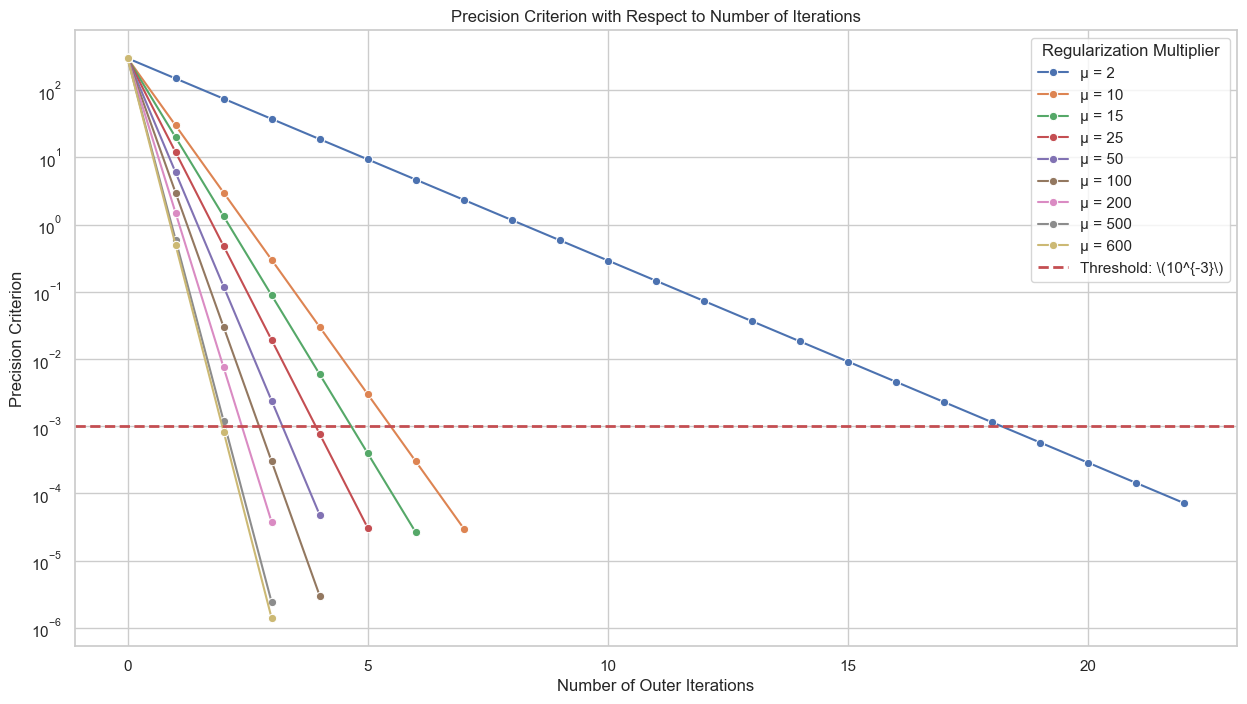

In [21]:
# Set the aesthetic style of the plots
sns.set_theme(style="whitegrid")

# Initialize the figure
plt.figure(figsize=(15, 8))

# Plot the precision criterion for each value of mu
for mu in mu_list:
    v_seq = barr_method(Q, p, A, b, v0, eps)
    precision_criterion = [len(A) / (mu ** i) for i in range(len(v_seq))]
    sns.lineplot(x=range(len(precision_criterion)), y=precision_criterion, marker='o', label=f'μ = {mu}')

# Set the y-axis to a logarithmic scale
plt.yscale('log')

# Add a horizontal dotted line at y = 10^-3
plt.axhline(y=1e-3, color='r', linestyle='--', linewidth=2, label='Threshold: \(10^{-3}\)')

# Customize the axes and title
plt.xlabel("Number of Outer Iterations")
plt.ylabel("Precision Criterion")
plt.title('Precision Criterion with Respect to Number of Iterations')

# Show the legend
plt.legend(title='Regularization Multiplier')

# Show the plot
plt.show()


#### <b> Observations </b>

- We defined previously our eps as 1e-4. What we observe is that as for the gap, there is indeed a convergence of the optimization methods towards this value.

### <b>3.d - Outer iterations vs mu

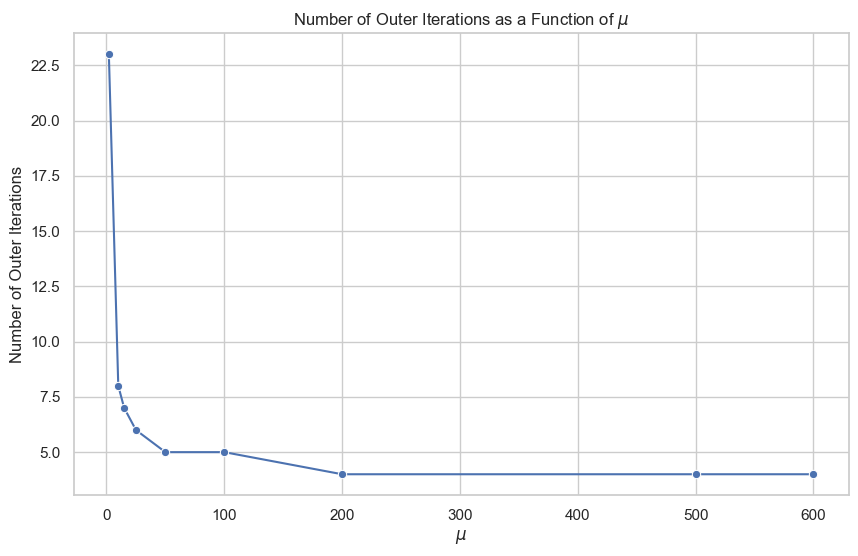

In [22]:
# Set the aesthetic style of the plots
sns.set_theme(style="whitegrid")

# Prepare the data for plotting
num_iterations = []  # To store the number of iterations for each mu
for mu in mu_list:
    v_seq = barr_method(Q, p, A, b, v0, eps)
    num_iterations.append(len(v_seq))  # Number of iterations for this mu

# Create a DataFrame to hold the values
data = pd.DataFrame({'$\mu$': mu_list, 'Number of Outer Iterations': num_iterations})

# Now plot mu vs. the number of outer iterations using seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(x='$\mu$', y='Number of Outer Iterations', data=data, marker='o')

# Customize the axes and title
plt.xlabel('$\mu$')
plt.ylabel('Number of Outer Iterations')
plt.title('Number of Outer Iterations as a Function of $\mu$')

# Show the plot
plt.show()


#### <b>Observations</b>

- The number of outer iterations required decreases sharply as mu increases from 0 to 50. That suggests that a higher mu results in fewer outer iterations in the range observed. If mu is low, the number of outer iterations is high, the algorithm takes smaller steps to find the optimum. As mu increases, the algorithm needs less steps, it is more efficient. Beyond a certain point (mu ≈ 50), the curve becomes relatively flat, with the number of outer iterations varying only slightly between approximately 4.5 and 5.5. 
  
- This plateau suggests that there is a limit to the effectiveness of increasing mu in terms of reducing the number of outer iterations. Therefore, based on the graph, there seems to be an optimal range of mu (around 50-200) where the number of outer iterations stabilizes. Operating within this range of mu values might provide a balance between computational efficiency and the precision of the steps taken by the algorithm.

### <b>3.e - Evolution of w

Distance for μ=8: 16.97265897657285
Solution for μ=8: 852179.7839539269

Distance for μ=9: 16.97265897652143
Solution for μ=9: 852179.7835318237

Distance for μ=10: 16.972658976553703
Solution for μ=10: 852179.7837967356

Distance for μ=15: 16.972658976542103
Solution for μ=15: 852179.7837015268

Distance for μ=25: 16.972658976496604
Solution for μ=25: 852179.7833280127

Distance for μ=50: 16.972658976297488
Solution for μ=50: 852179.7816934922

Distance for μ=55: 16.972658976370308
Solution for μ=55: 852179.7822912586

Distance for μ=60: 16.97265897642085
Solution for μ=60: 852179.782706165

Distance for μ=75: 16.972658976503542
Solution for μ=75: 852179.7833849895

Distance for μ=100: 16.972658976553703
Solution for μ=100: 852179.7837967356

Distance for μ=150: 16.972658974963505
Solution for μ=150: 852179.7707432723

Distance for μ=200: 16.972658975675245
Solution for μ=200: 852179.7765856158

Distance for μ=300: 16.97265897618361
Solution for μ=300: 852179.7807587172

Distance for 

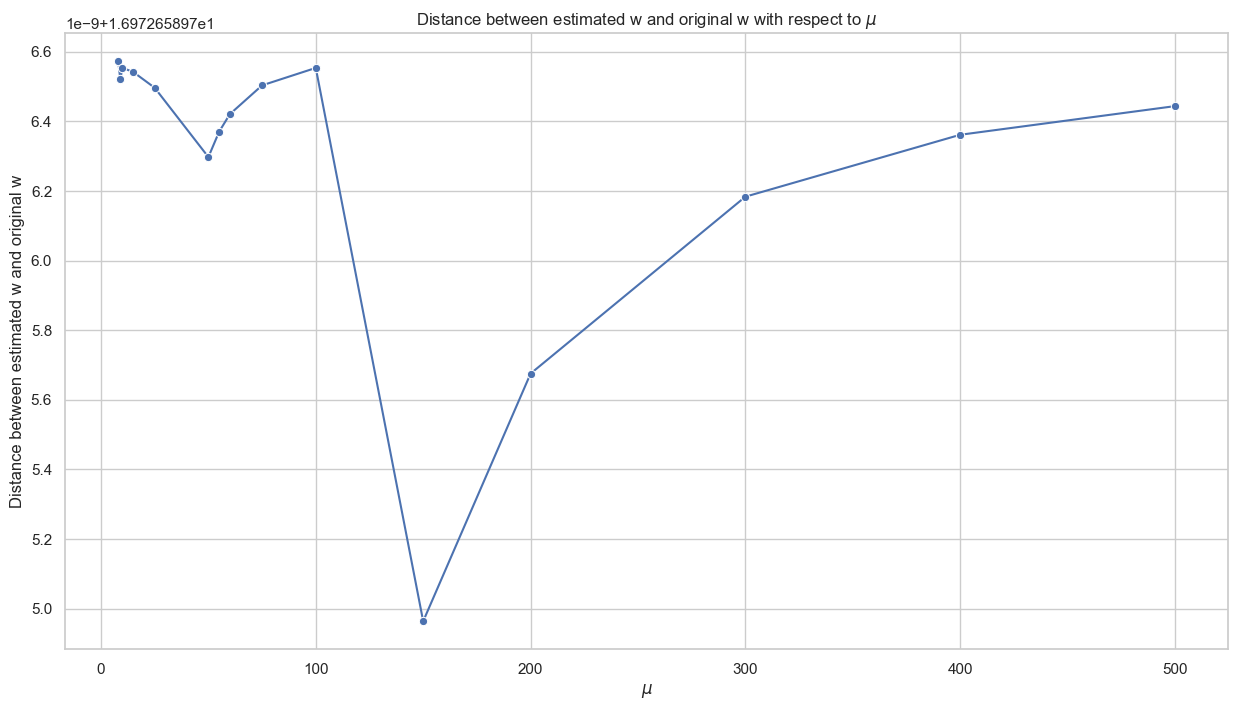

,mu,Distance,Solution
0,8,16.972659,852179.783954
1,9,16.972659,852179.783532
2,10,16.972659,852179.783797
3,15,16.972659,852179.783702
4,25,16.972659,852179.783328
5,50,16.972659,852179.781693
6,55,16.972659,852179.782291
7,60,16.972659,852179.782706
8,75,16.972659,852179.783385
9,100,16.972659,852179.783797


In [23]:
# repeat on different values of mu
# check the inpact on w 

mu_list = [8,9,10, 15,25, 50,55,60,75,100, 150,200,300,400,500]
distances = []
solutions = []

for mu in mu_list : 
    
    v_seq  = barr_method (Q, p, A, b, v0, eps)   
    # After solving KKT
    # gradient of the Lagrangian respect to z = 0
    # z* = nu *
    # Xw* - y = nu*
    # w* = (X.TX)^-1 X.T(- y - nu*)

    w_est = (np.linalg.pinv(X) @ (y + v_seq[-1])) / (np.linalg.norm(np.linalg.pinv(X) @ (y + v_seq[-1])))
    w_norm = w_true / np.linalg.norm(w_true)
    w_est_r = (np.linalg.pinv(X) @ (y + v_seq[-1]))    
    distance = np.linalg.norm(w_est - w_norm)
    distances.append(distance)
    print(f"Distance for μ={mu}: {distance}")
    # Solution of the problem
    # 0.5 * ||y - Xw||^2 + lambda * ||w||_1
    # give me the python script for the solution
    solution = 0.5 * np.linalg.norm(y - X @ w_est_r)**2 + regularization_lambda * np.linalg.norm(w_est_r, 1)
    solutions.append(solution)
    print(f"Solution for μ={mu}: {solution}")
    print("")

# Convert the lists to a DataFrame
data = pd.DataFrame({'mu': mu_list, 'Distance': distances})
results = pd.DataFrame({'mu': mu_list, 'Distance': distance, 'Solution': solutions})

# Plot using seaborn
sns.set_theme(style="whitegrid")
plt.figure(figsize=(15, 8))
sns.lineplot(x='mu', y='Distance', data=data, marker='o')

# Labeling the plot
plt.ylabel("Distance between estimated w and original w")
plt.xlabel('$\mu$')
plt.title('Distance between estimated w and original w with respect to $\mu$')

# Display the plot
plt.show()

# display results
results


#### <b>Observations</b>

- The distance between the estimated w and the original w is almost always the same, meaning that mu value will always give the same convergence result.

### <b>3.f - Find the optimal value with cvxpy

In [24]:
w = cp.Variable((d,1))
objec = cp.Minimize(0.5*cp.sum_squares(X @ w - y) + regularization_lambda*cp.norm(w,1))
prob = cp.Problem(objec)
result = prob.solve()
print("Optimal value",result)


Optimal value 4787.527249322645


#### <b> Observations </b>

- What we observe is that the optimal value can also be given by cvxpy.

- To conclude, with all the observations, we can say that the barrier method is a working method and that we have to be aware on which parameters to choose, mu can be choosen between the range [40 - 120] based on our observations.

- This homework has been an interessting exploration into the field of constrained optimization. It has shown its efficiency in handling optimization problems with inequality constraints. Throughout this practical, we observed how the method went through the feasible region by incorporating barrier functions into the objective function.

----
<center>
END
</center>

